## Example Analysis of whales clicks
This notebook is an example for how the whale click dataset can be analyzed.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pyspark import SparkContext
sc = SparkContext(pyFiles=['lib/numpy_pack.py','lib/row_parser.py','lib/spark_PCA.py'])

from pyspark.sql import Row, SQLContext,DataFrame
from pyspark.sql.types import *

sqlContext = SQLContext(sc)

%pylab inline

#!pip install pandas
#!pip install scipy

import pandas as pd
import datetime as dt

from scipy.io import loadmat,savemat,whosmat

from string import split
from collections import Counter
import re
import numpy as np
from numpy import shape

from glob import glob
from time import time

Populating the interactive namespace from numpy and matplotlib


In [7]:
import sys
sys.path.append('lib')
from row_parser import *

Parse_rules,field_names,RowObject = init_parser_parameters()

from pyspark.sql import DataFrame

CVS_Data=sc.textFile("/CVS/*/")
row=CVS_Data.first()
print row

def parse(row):
    items=row.split(',')
    D=[]
    for pr in Parse_rules:
        start=pr['start']
        end=pr['end']
        parser=pr['parser']
        if end-start==1:
            D.append(parser(items[start]))
        else:
            D.append(parser(items[start:end]))
    return RowObject(*D)

#parse(row)

RDD=CVS_Data.map(parse)
# RDD.take(3)

df=sqlContext.createDataFrame(RDD)
df.show()

('time', 'datetime') {'start': 0, 'parser': <function parse_date at 0x7f58b4dc85f0>, 'end': 1, 'name': 'time'}
('species', 'str') {'start': 1, 'parser': <function parse_string at 0x7f58b4dc8500>, 'end': 2, 'name': 'species'}
('site', 'str') {'start': 2, 'parser': <function parse_string at 0x7f58b4dc8500>, 'end': 3, 'name': 'site'}
('rec_no', 'str') {'start': 3, 'parser': <function parse_string at 0x7f58b4dc8500>, 'end': 4, 'name': 'rec_no'}
('bout_i', 'int') {'start': 4, 'parser': <function parse_int at 0x7f58b4dc8668>, 'end': 5, 'name': 'bout_i'}
('peak2peak', 'float') {'start': 5, 'parser': <function parse_float at 0x7f58b4dc8578>, 'end': 6, 'name': 'peak2peak'}
('MSN', 'array', 202) {'start': 6, 'parser': <function parse_array at 0x7f58b4dc8320>, 'end': 208, 'name': 'MSN'}
('MSP', 'array', 101) {'start': 208, 'parser': <function parse_array at 0x7f58b4dc8320>, 'end': 309, 'name': 'MSP'}
('TPWS1', 'bool') {'start': 309, 'parser': <function parse_int at 0x7f58b4dc8668>, 'end': 310, 'n

In [8]:
t0=time()
print df.cache().count()
print time()-t0

t0=time()
print df.count()
time()-t0

6353182
49.0883829594
6353182


0.8999240398406982

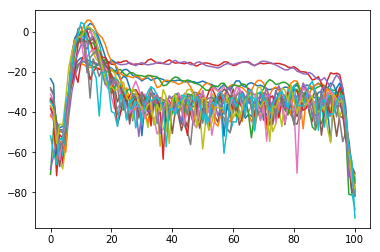

In [9]:
from row_parser import unpackArray
import numpy
def g(row):
    #return numpy.array([1,2]) #
    return unpackArray(row.MSP,data_type=numpy.float64)
def unpackArray(x,data_type=numpy.int16):
    return numpy.frombuffer(x,dtype=data_type)
L=df.take(20)
for a in L:
    plot(g(a))

In [13]:
spectra=df.rdd.map(g)
type(spectra.first())

numpy.ndarray

In [14]:
spectra.cache().count()

6353182

In [15]:
from time import time
from spark_PCA import *

In [16]:
t0=time()
COV=computeCov(spectra)
print time()-t0

shape of E= (101,) shape of NE= (101,)
34.3031938076


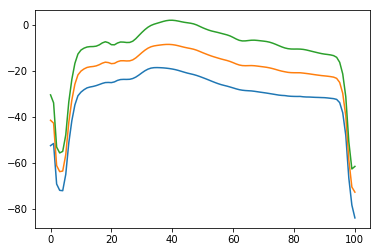

In [17]:
M=COV['Mean']
S=np.sqrt(COV['Var'])
plot(M-S)
plot(M)
plot(M+S)

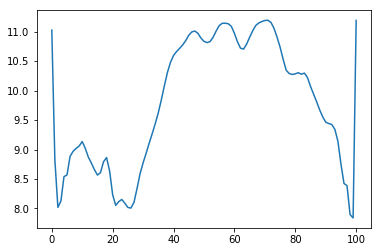

In [18]:
plot(np.sqrt(COV['Var']))

In [19]:
eigval,eigvec=LA.eig(COV['Cov'])

In [20]:
eigval=eigval/sum(eigval)
sum(eigval)

1.0000000000000002

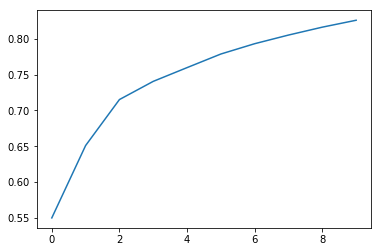

In [21]:
plot(cumsum(eigval[:10]))

In [22]:
shape(eigvec)

(101, 101)

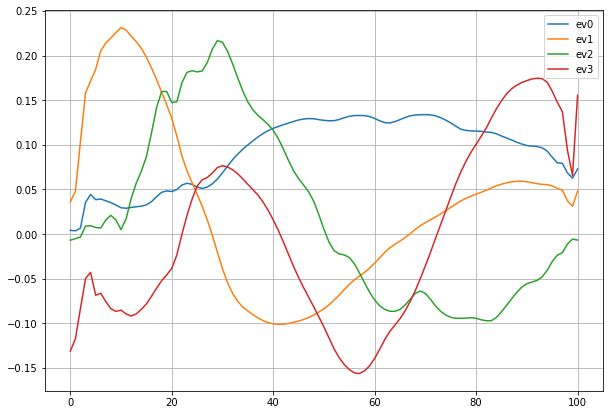

In [23]:
figure(figsize=[10,7])
for i in range(4):
    plot(eigvec[:,i],label='ev'+str(i))
legend()
grid()

In [24]:
sum(eigvec[:,1]**2)

0.99999999999999989

In [25]:
#Cuviers=df.filter(df.species==u'Cuviers' & df.TPWS2==1)
Cuviers=df.filter(df.TPWS2==1).filter(df.species==u'Cuviers')

In [26]:
Gervais=df.filter(df.TPWS2==1).filter(df.species==u'Gervais')

In [27]:
V=eigvec[:,1:3] #vectors on which to project
def project(row):
    X=unpackArray(row.MSP,data_type=np.float64)
    return np.dot(X,V)

In [29]:
Cuvier_projections=np.array(Cuviers.sample(False,0.001).rdd.map(project).take(10000))
Gervais_projections=np.array(Gervais.sample(False,0.001).rdd.map(project).take(10000))

(-50, 50)

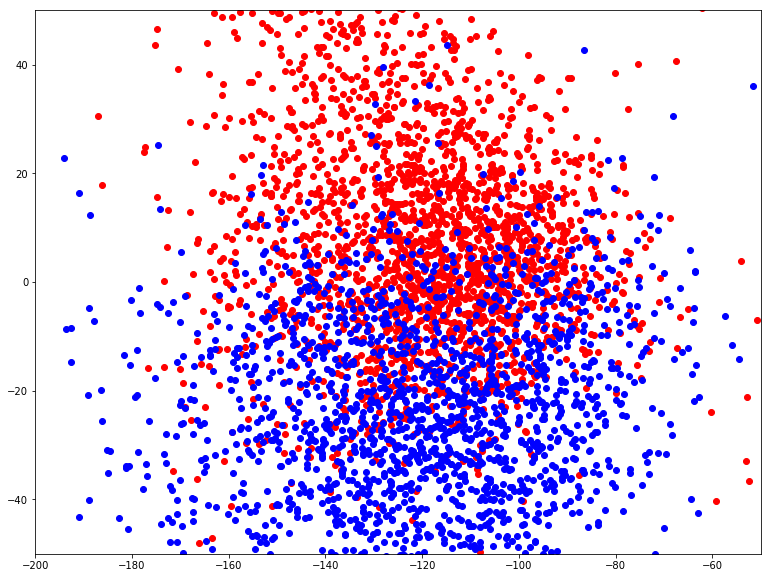

In [30]:
figure(figsize=[13,10])
scatter(Cuvier_projections[:,0],Cuvier_projections[:,1],c='r')
scatter(Gervais_projections[:,0],Gervais_projections[:,1],c='b')
xlim([-200,-50])
ylim([-50,50])